Importing necessery stuff

In [2]:
import cv2
import random
from PIL import Image
import numpy as np
import math
from matplotlib import pyplot as plt
import time
import json

If this shit aint working, your cuda is probably fucked up

In [3]:
import torch
from torchsummary import summary
from pathlib import Path

Creating dataset

In [4]:
DATASET_NAME = "Squares_new_2"

Defining NN and creating instance of it

In [5]:
class HuiNet(torch.nn.Module):
    def __init__(self):
        super(HuiNet, self).__init__()
        self.layers_indexes = dict()
        self.conv_lays = [1, 8, 16]
        counter = 0
        self.layers_list = []
        
        num_convs = 2
        num_fc = 10

        for i in range(num_convs):
            self.layers_list.append(torch.nn.Conv2d(in_channels=self.conv_lays[i], out_channels=self.conv_lays[
                i + 1], kernel_size=8, padding=3, stride=2))
            self.layers_indexes["cv" + str(i + 1)] = counter
            counter += 1
            self.layers_list.append(torch.nn.ReLU())
            self.layers_indexes["act" + str(i + 1)] = counter
            counter += 1
            self.layers_list.append(torch.nn.MaxPool2d(kernel_size=2, stride=2))
            self.layers_indexes["pool" + str(i + 1)] = counter
            counter += 1

        self.layers_list.append(torch.nn.Linear(16*16*16, 1000))
        self.layers_indexes['fc1'] = counter
        counter += 1
        self.layers_list.append(torch.nn.ReLU())
        self.layers_indexes[f'act{num_convs + 1}'] = counter
        counter += 1
    
        for i in range(1, num_fc):
            if i == num_fc-1:
                self.layers_list.append(torch.nn.Linear(100, 5))
                self.layers_indexes[f"fc{i+1}"] = counter
                counter += 1
            elif i == 1:
                self.layers_list.append(torch.nn.Linear(1000, 100))
                self.layers_indexes[f"fc{i+1}"] = counter
                counter += 1
            else:
                self.layers_list.append(torch.nn.Linear(100, 100))
                self.layers_indexes[f"fc{i+1}"] = counter
                counter += 1
                self.layers_list.append(torch.nn.ReLU())
                self.layers_indexes[f"act{i+num_convs + 2}"] = counter
                counter += 1
        self.layers_list = torch.nn.ModuleList(self.layers_list)

    def forward(self, x):
        for key in self.layers_indexes:
            if key == "fc1":
                x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
            x = self.layers_list[self.layers_indexes[key]](x)
        return x


FOLDER_FOR_NETWORKS_EPOCH = "states_29.08.22_try1"
Path(f"States/{FOLDER_FOR_NETWORKS_EPOCH}").mkdir(parents=True, exist_ok=True)

huinet = HuiNet()

start_epoch = 151

if start_epoch != 1:
    huinet.load_state_dict(torch.load(f"States/{FOLDER_FOR_NETWORKS_EPOCH}/state{start_epoch-1}.txt"))
    huinet.eval()
else:
    dictForJson = dict()
    for key in huinet.layers_indexes.keys():
        dictForJson[key] = str(huinet.layers_list[huinet.layers_indexes[key]])
    with open(f"States/{FOLDER_FOR_NETWORKS_EPOCH}/0_model_description", "w") as outfile:
        json.dump(dictForJson, outfile)
        
huinet.float()


HuiNet(
  (layers_list): ModuleList(
    (0): Conv2d(1, 8, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Linear(in_features=4096, out_features=1000, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1000, out_features=100, bias=True)
    (9): Linear(in_features=100, out_features=100, bias=True)
    (10): ReLU()
    (11): Linear(in_features=100, out_features=100, bias=True)
    (12): ReLU()
    (13): Linear(in_features=100, out_features=100, bias=True)
    (14): ReLU()
    (15): Linear(in_features=100, out_features=100, bias=True)
    (16): ReLU()
    (17): Linear(in_features=100, out_features=100, bias=True)
    (18): ReLU()
    (19): Linear(in_features=100, out_features=100, bias=True)
    (20): R

In [10]:
summary(huinet,(1,256,256))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

Custom loss

In [6]:
PARAMS = {
    "dist_loss": 1,
    "size_loss": 1,
    "angle_loss": 1
}

mse_loss = torch.nn.MSELoss()

def my_greatest_loss(target, result, params,tensor_board = None, N = -1, print_state=False):
    global mse_loss

    errs = torch.empty_like(target).to(torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))
    errs = target - result
    errs /= torch.tensor([255, 255, 255, 255, 180]).to(torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))
    # errs = torch.nn.functional.normalize(errs)
    loss_dist = (errs[:,0] ** 2 + errs[:,1] ** 2) * params.get("dist_loss")
    loss_size = (errs[:,2] **2 + errs[:,3]**2) * params.get("size_loss")
    loss_angle = errs[:,4] ** 2 * params.get("angle_loss")
    # loss = np.sum(np.linalg.norm(errs.cpu().detach(), axis=0)**2)
    if print_state:
        print(f"Distance loss: {torch.mean(loss_dist)} Size loss: {torch.mean(loss_size)} Angle loss: {torch.mean(loss_angle)}")
    loss_ = loss_dist + loss_size + loss_angle
    if N != -1:
        tensor_board.add_scalar("loss_dist",loss_dist.sum(), N)
        tensor_board.add_scalar("loss_size",loss_size.sum(), N)
        tensor_board.add_scalar("loss_angle",loss_angle.sum(), N)
    del errs
    torch.cuda.empty_cache()
    return loss_.sum()

To GPU if avaliable

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
huinet = huinet.to(device)
device

device(type='cuda', index=0)

Setting loss and optimizer

In [8]:
# loss = my_greatest_loss
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(huinet.parameters(), lr=1.0e-3)

Getting test dataset

In [9]:
f = open(f"Datasets/{DATASET_NAME}/labels.txt")
f = f.readlines()
N = len(f)
print(N)
N_test = math.floor(0.98 * N)

X_test = torch.zeros((N - N_test, 1, 256, 256))
y_test = torch.zeros(N - N_test, 5)

for i in range(N_test, N):
    name, label = f[i].split()
    label = torch.tensor(list(map(int, label.split("_"))))
    y_test[i - N_test] += label
    img = Image.open(f"Datasets/{DATASET_NAME}/" + name)
    X_test[i - N_test] += torch.tensor(np.asarray(img)).resize(3, 256, 256)[0, :]

50000


/home/youbot/.local/lib/python3.8/site-packages/torch/_tensor.py:586: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Importing torchision for beatiful graphs

In [10]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from itertools import product
from tqdm import tqdm

Learning process. Each epoch is saved 

In [16]:
batch_size = 16
N_epochs = 1000

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)
tb = SummaryWriter()

norm =  torch.tensor([255, 255, 255, 255, 180])#.to(torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))

for epoch in range(N_epochs):
    order = np.random.permutation(N_test)
    current_losses = []
    time_start = time.time()
    
    for start_index in tqdm(range(0, N_test, batch_size),leave=False):
        torch.cuda.empty_cache()
        X_train = torch.zeros((batch_size,1,256,256))
        y_train = torch.zeros((batch_size,5))
        for i in range(start_index, start_index + batch_size):
            name, label = f[i].split()
            label = torch.tensor(list(map(int, label.split("_"))))/norm
            y_train[i%batch_size] += label
            img = Image.open(f"Datasets/{DATASET_NAME}/" + name)
            X_train[i%batch_size] += torch.tensor(np.asarray(img)).reshape(3, 256, 256)[0, :]/255
        optimizer.zero_grad()

        X_batch = X_train.to(device)
        y_batch = y_train.to(device)

        preds = huinet.forward(X_batch)

        loss_value = loss(preds, y_batch)
        current_losses.append(loss_value.item())
        loss_value.backward()
        tb.add_scalar("Batch",loss_value.item(), epoch * N_test//batch_size + start_index//batch_size)

        optimizer.step()
        del X_train, y_train, label
        torch.cuda.empty_cache()

    test_preds = huinet.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).item())
    # # TODO: новая accuracy когда-нибудь
    # # accuracy = (test_preds.argmax(dim=0) == y_test).float().mean().data.cpu()
    accuracy = np.array(current_losses).mean()
    test_accuracy_history.append(accuracy)
    print(f"Epoch: {epoch+start_epoch}/{start_epoch+N_epochs-1} Accuracy: {accuracy} Time:{time.time()-time_start} Last loss: {test_loss_history[-1]}")
    tb.add_scalar("Accuracy",accuracy, epoch)
    del test_preds, accuracy
    torch.cuda.empty_cache()
    torch.save(huinet.state_dict(), f"States/{FOLDER_FOR_NETWORKS_EPOCH}/state{start_epoch + epoch}.txt")

Epoch: 1/1000 Accuracy: 0.03423037761509166 Time:136.731614112854 Last loss: 11764.80859375


Epoch: 2/1000 Accuracy: 0.02652676767750801 Time:119.02345299720764 Last loss: 11847.4990234375


Epoch: 3/1000 Accuracy: 0.02497923405676195 Time:117.42192363739014 Last loss: 11946.828125


Epoch: 4/1000 Accuracy: 0.02403559592448192 Time:113.8514461517334 Last loss: 11902.37109375


Epoch: 5/1000 Accuracy: 0.023248173726842396 Time:110.10190653800964 Last loss: 12064.1181640625


Epoch: 6/1000 Accuracy: 0.022613507468366482 Time:110.09468293190002 Last loss: 12192.111328125


Epoch: 7/1000 Accuracy: 0.022151708192582123 Time:110.251460313797 Last loss: 12125.9697265625


Epoch: 8/1000 Accuracy: 0.02162485517524341 Time:110.79515099525452 Last loss: 12136.6865234375


Epoch: 9/1000 Accuracy: 0.021470845602616945 Time:110.51773881912231 Last loss: 11925.248046875


Epoch: 10/1000 Accuracy: 0.020869687429762748 Time:111.19342112541199 Last loss: 12199.85546875


Epoch: 11/1000 Accuracy: 0.02041177492232405 Time:110.05143523216248 Last loss: 12447.685546875


Epoch: 12/1000 Accuracy: 0.020066019425389377 Time:111.06246733665466 Last loss: 12728.7705078125


Epoch: 13/1000 Accuracy: 0.019753554894294256 Time:110.38888716697693 Last loss: 12579.740234375


Epoch: 14/1000 Accuracy: 0.019518932050329348 Time:110.103524684906 Last loss: 12776.912109375


Epoch: 15/1000 Accuracy: 0.019402379548153405 Time:110.40166759490967 Last loss: 12730.01171875


Epoch: 16/1000 Accuracy: 0.01920438834660332 Time:111.48254537582397 Last loss: 12744.08984375


Epoch: 17/1000 Accuracy: 0.01902360803700942 Time:110.54919195175171 Last loss: 12924.380859375


Epoch: 18/1000 Accuracy: 0.01887334421626102 Time:110.3445737361908 Last loss: 12842.5087890625


Epoch: 19/1000 Accuracy: 0.018822703011111375 Time:110.06913828849792 Last loss: 12901.115234375


Epoch: 20/1000 Accuracy: 0.018748081063774485 Time:112.24248623847961 Last loss: 12714.2744140625


Epoch: 21/1000 Accuracy: 0.018599665610024227 Time:110.43641209602356 Last loss: 13000.9658203125


Epoch: 22/1000 Accuracy: 0.018479985905427473 Time:110.26273798942566 Last loss: 13063.283203125


Epoch: 23/1000 Accuracy: 0.018454161344155052 Time:110.2473783493042 Last loss: 13093.8369140625


Epoch: 24/1000 Accuracy: 0.018349907616377753 Time:110.16481494903564 Last loss: 13071.0341796875


Epoch: 25/1000 Accuracy: 0.018301750795682817 Time:112.32425737380981 Last loss: 13153.181640625


Epoch: 26/1000 Accuracy: 0.018196287655845952 Time:110.51639676094055 Last loss: 13303.76171875


Epoch: 27/1000 Accuracy: 0.01821708083759362 Time:110.17199158668518 Last loss: 13358.69921875


Epoch: 28/1000 Accuracy: 0.018141793998835806 Time:110.31466698646545 Last loss: 13388.9814453125


Epoch: 29/1000 Accuracy: 0.01812276543468332 Time:110.29986310005188 Last loss: 13274.291015625


Epoch: 30/1000 Accuracy: 0.01809225822326101 Time:110.32321548461914 Last loss: 13135.94140625


Epoch: 31/1000 Accuracy: 0.018041631557750345 Time:112.81814742088318 Last loss: 13219.5625


Epoch: 32/1000 Accuracy: 0.01809684534040573 Time:110.4972174167633 Last loss: 13184.6552734375


Epoch: 33/1000 Accuracy: 0.01797080208022005 Time:110.2036063671112 Last loss: 13296.01953125


Epoch: 34/1000 Accuracy: 0.017991784273853832 Time:110.53580617904663 Last loss: 13162.216796875


Epoch: 35/1000 Accuracy: 0.01788513486013923 Time:110.80805993080139 Last loss: 13291.79296875


Epoch: 36/1000 Accuracy: 0.017917699752168118 Time:110.63080167770386 Last loss: 13394.7666015625


Epoch: 37/1000 Accuracy: 0.017900210263182014 Time:110.17697381973267 Last loss: 13218.09765625


Epoch: 38/1000 Accuracy: 0.01787269495091931 Time:110.36131525039673 Last loss: 13129.037109375


Epoch: 39/1000 Accuracy: 0.017828959354205247 Time:114.11046433448792 Last loss: 13017.61328125


Epoch: 40/1000 Accuracy: 0.017833051024995432 Time:110.1187686920166 Last loss: 13162.7802734375


Epoch: 41/1000 Accuracy: 0.017826800596366058 Time:110.32862901687622 Last loss: 13053.673828125


Epoch: 42/1000 Accuracy: 0.017821749536684826 Time:110.31411862373352 Last loss: 13101.2216796875


Epoch: 43/1000 Accuracy: 0.01784955029171526 Time:110.33592414855957 Last loss: 13081.59375


Epoch: 44/1000 Accuracy: 0.017799429386660185 Time:110.5717601776123 Last loss: 13283.1318359375


Epoch: 45/1000 Accuracy: 0.0177253769759917 Time:110.18598294258118 Last loss: 13416.7041015625


Epoch: 46/1000 Accuracy: 0.017808506951308277 Time:110.52300310134888 Last loss: 13202.2666015625


Epoch: 47/1000 Accuracy: 0.01774205488021754 Time:110.80646443367004 Last loss: 13018.6474609375


Epoch: 48/1000 Accuracy: 0.01777184141846632 Time:114.0908305644989 Last loss: 13112.8544921875


Epoch: 49/1000 Accuracy: 0.017704545037177555 Time:110.56559658050537 Last loss: 13240.1484375


Epoch: 50/1000 Accuracy: 0.017806749622156 Time:110.3178083896637 Last loss: 13220.9697265625


Epoch: 51/1000 Accuracy: 0.017725977060983125 Time:110.55116367340088 Last loss: 13227.98046875


Epoch: 52/1000 Accuracy: 0.01776831123827088 Time:110.17380499839783 Last loss: 13324.669921875


Epoch: 53/1000 Accuracy: 0.01772044399261251 Time:110.61215305328369 Last loss: 13330.4609375


Epoch: 54/1000 Accuracy: 0.017698230687300805 Time:110.56948471069336 Last loss: 13418.5546875


Epoch: 55/1000 Accuracy: 0.017719354970946816 Time:110.61070895195007 Last loss: 13270.92578125


Epoch: 56/1000 Accuracy: 0.017693760230622812 Time:110.56786179542542 Last loss: 13268.943359375


Epoch: 57/1000 Accuracy: 0.017689708596137402 Time:110.71957516670227 Last loss: 13192.03125


Epoch: 58/1000 Accuracy: 0.017662852858159772 Time:110.71144151687622 Last loss: 13409.6796875


Epoch: 59/1000 Accuracy: 0.01765915053919258 Time:110.61972570419312 Last loss: 13300.7568359375


Epoch: 60/1000 Accuracy: 0.017695221959266944 Time:110.58656740188599 Last loss: 13145.095703125


Epoch: 61/1000 Accuracy: 0.017733853519156847 Time:115.07748937606812 Last loss: 13319.0927734375


Epoch: 62/1000 Accuracy: 0.01763011761155792 Time:110.55942058563232 Last loss: 13393.515625


Epoch: 63/1000 Accuracy: 0.017670307097420793 Time:110.5129759311676 Last loss: 13611.51171875


Epoch: 64/1000 Accuracy: 0.017622793000510707 Time:110.3475694656372 Last loss: 13384.6748046875


Epoch: 65/1000 Accuracy: 0.01764566001958611 Time:110.60029196739197 Last loss: 13413.767578125


Epoch: 66/1000 Accuracy: 0.017624792713850403 Time:110.56117415428162 Last loss: 13394.486328125


Epoch: 67/1000 Accuracy: 0.017658133636419687 Time:110.45182013511658 Last loss: 13364.953125


Epoch: 68/1000 Accuracy: 0.017606615290088914 Time:110.65235018730164 Last loss: 13380.6767578125


Epoch: 69/1000 Accuracy: 0.017602492119053362 Time:110.62961888313293 Last loss: 13364.4873046875


Epoch: 70/1000 Accuracy: 0.017649194336421193 Time:110.31862926483154 Last loss: 13183.3310546875


Epoch: 71/1000 Accuracy: 0.017635167887003516 Time:110.2903881072998 Last loss: 13292.3486328125


Epoch: 72/1000 Accuracy: 0.017641540349637795 Time:110.66521716117859 Last loss: 13154.6865234375


Epoch: 73/1000 Accuracy: 0.017573374499063033 Time:110.86194133758545 Last loss: 13326.1416015625


Epoch: 74/1000 Accuracy: 0.017598645314495186 Time:110.39784002304077 Last loss: 13299.9375


Epoch: 75/1000 Accuracy: 0.017728639057592054 Time:110.78648328781128 Last loss: 13519.458984375


Epoch: 76/1000 Accuracy: 0.01759129869585922 Time:116.6921558380127 Last loss: 13476.0654296875


Epoch: 77/1000 Accuracy: 0.017554301014179173 Time:111.69709348678589 Last loss: 13674.849609375


Epoch: 78/1000 Accuracy: 0.017552144727666617 Time:110.59093856811523 Last loss: 13601.7802734375


Epoch: 79/1000 Accuracy: 0.017589979781183908 Time:110.60115671157837 Last loss: 13709.8369140625


Epoch: 80/1000 Accuracy: 0.017586964301859527 Time:110.15454268455505 Last loss: 13528.1689453125


Epoch: 81/1000 Accuracy: 0.017570631691597345 Time:110.52678275108337 Last loss: 13604.115234375


Epoch: 82/1000 Accuracy: 0.017606927380031154 Time:110.82230973243713 Last loss: 13535.2958984375


Epoch: 83/1000 Accuracy: 0.017642880814868155 Time:110.72236490249634 Last loss: 13663.2314453125


Epoch: 84/1000 Accuracy: 0.01760933025783567 Time:110.35991740226746 Last loss: 13743.2431640625


Epoch: 85/1000 Accuracy: 0.017554167382654143 Time:110.4852249622345 Last loss: 13608.328125


Epoch: 86/1000 Accuracy: 0.01753514148286564 Time:110.38833498954773 Last loss: 13596.71484375


Epoch: 87/1000 Accuracy: 0.01755389465036438 Time:110.63677930831909 Last loss: 13640.53125


Epoch: 88/1000 Accuracy: 0.017567546545741324 Time:110.65064859390259 Last loss: 13515.8955078125


Epoch: 89/1000 Accuracy: 0.0175208369132914 Time:110.59932971000671 Last loss: 13478.2880859375


Epoch: 90/1000 Accuracy: 0.01758009327922644 Time:110.3495523929596 Last loss: 13717.228515625


Epoch: 91/1000 Accuracy: 0.017518777052415495 Time:110.3437328338623 Last loss: 13510.6396484375


Epoch: 92/1000 Accuracy: 0.017460534751615624 Time:110.60574913024902 Last loss: 13565.65234375


Epoch: 93/1000 Accuracy: 0.017526189407207245 Time:110.52181029319763 Last loss: 13530.1591796875


Epoch: 94/1000 Accuracy: 0.017598744322096738 Time:110.76134467124939 Last loss: 13482.23046875


Epoch: 95/1000 Accuracy: 0.017525343523673055 Time:117.54075288772583 Last loss: 13393.666015625


Epoch: 96/1000 Accuracy: 0.017625666985657994 Time:110.36270761489868 Last loss: 13324.6318359375


Epoch: 97/1000 Accuracy: 0.017824591091404378 Time:110.63576745986938 Last loss: 13295.330078125


Epoch: 98/1000 Accuracy: 0.017506787567074102 Time:110.38453030586243 Last loss: 13318.0537109375


Epoch: 99/1000 Accuracy: 0.017487469742582685 Time:110.5694272518158 Last loss: 13227.1201171875


Epoch: 100/1000 Accuracy: 0.017552417873282083 Time:110.54677319526672 Last loss: 13154.55859375


Epoch: 101/1000 Accuracy: 0.017565906998109095 Time:110.70869255065918 Last loss: 13300.416015625


Epoch: 102/1000 Accuracy: 0.01749683672773104 Time:110.63523483276367 Last loss: 13346.400390625


Epoch: 103/1000 Accuracy: 0.017506682926156793 Time:110.74407410621643 Last loss: 13324.7880859375


Epoch: 104/1000 Accuracy: 0.017552469134448724 Time:110.88522362709045 Last loss: 13391.5341796875


Epoch: 105/1000 Accuracy: 0.017496086548461385 Time:110.92459154129028 Last loss: 13332.5849609375


Epoch: 106/1000 Accuracy: 0.01763927775545066 Time:110.55342102050781 Last loss: 13239.7763671875


Epoch: 107/1000 Accuracy: 0.017530570509329674 Time:110.52924704551697 Last loss: 13208.4697265625


Epoch: 108/1000 Accuracy: 0.01751155064820117 Time:110.50657486915588 Last loss: 13323.4951171875


Epoch: 109/1000 Accuracy: 0.01748517299686059 Time:110.59074544906616 Last loss: 13395.54296875


Epoch: 110/1000 Accuracy: 0.017510474939423773 Time:110.72858738899231 Last loss: 13276.3056640625


Epoch: 111/1000 Accuracy: 0.017585526887066553 Time:110.48080921173096 Last loss: 13522.9150390625


Epoch: 112/1000 Accuracy: 0.01751742130409199 Time:110.90669298171997 Last loss: 13691.439453125


Epoch: 113/1000 Accuracy: 0.017512728841836987 Time:110.53223490715027 Last loss: 13724.0732421875


Epoch: 114/1000 Accuracy: 0.017587702405899568 Time:110.59080266952515 Last loss: 13594.748046875


Epoch: 115/1000 Accuracy: 0.017486777757937555 Time:110.17908811569214 Last loss: 13701.3232421875


Epoch: 116/1000 Accuracy: 0.017455199640259447 Time:110.50863718986511 Last loss: 13570.5087890625


Epoch: 117/1000 Accuracy: 0.0174864575053543 Time:110.65419340133667 Last loss: 13712.5517578125


Epoch: 118/1000 Accuracy: 0.01753196260910706 Time:119.71001195907593 Last loss: 13292.6181640625


Epoch: 119/1000 Accuracy: 0.017531145384227793 Time:110.72286701202393 Last loss: 13497.4111328125


Epoch: 120/1000 Accuracy: 0.017497661579961285 Time:110.77097582817078 Last loss: 13795.11328125


Epoch: 121/1000 Accuracy: 0.017451261287117867 Time:110.90726494789124 Last loss: 13623.2666015625


Epoch: 122/1000 Accuracy: 0.01749634433550188 Time:110.433358669281 Last loss: 13571.3984375


Epoch: 123/1000 Accuracy: 0.01746016093760843 Time:110.63320326805115 Last loss: 13377.716796875


Epoch: 124/1000 Accuracy: 0.017481456089263447 Time:110.76852822303772 Last loss: 13624.927734375


Epoch: 125/1000 Accuracy: 0.017616998885470584 Time:110.7037603855133 Last loss: 13538.85546875


Epoch: 126/1000 Accuracy: 0.017450456409864104 Time:110.79972553253174 Last loss: 13677.46875


Epoch: 127/1000 Accuracy: 0.01750840968589219 Time:110.52031326293945 Last loss: 13491.318359375


Epoch: 128/1000 Accuracy: 0.017487566329824938 Time:110.41539645195007 Last loss: 13357.8046875


Epoch: 129/1000 Accuracy: 0.017475351490835327 Time:110.56816148757935 Last loss: 13478.2607421875


Epoch: 130/1000 Accuracy: 0.01751879941799182 Time:110.50559163093567 Last loss: 13547.3037109375


Epoch: 131/1000 Accuracy: 0.017473695688918076 Time:110.76928234100342 Last loss: 13395.640625


Epoch: 132/1000 Accuracy: 0.017427689805978055 Time:110.65989923477173 Last loss: 13288.7978515625


Epoch: 133/1000 Accuracy: 0.0175060879665561 Time:110.57651591300964 Last loss: 13333.7705078125


Epoch: 134/1000 Accuracy: 0.017475476187455898 Time:110.5426676273346 Last loss: 13216.5


Epoch: 135/1000 Accuracy: 0.01749041965894901 Time:110.42028212547302 Last loss: 13373.865234375


Epoch: 136/1000 Accuracy: 0.017473579701782673 Time:110.41162276268005 Last loss: 13289.7255859375


Epoch: 137/1000 Accuracy: 0.017497407710944386 Time:110.4999406337738 Last loss: 13634.0185546875


Epoch: 138/1000 Accuracy: 0.017509058548029303 Time:110.40502834320068 Last loss: 13547.7998046875


Epoch: 139/1000 Accuracy: 0.01744982931959658 Time:110.39845418930054 Last loss: 13502.416015625


Epoch: 140/1000 Accuracy: 0.017514774830476146 Time:110.62881398200989 Last loss: 13524.166015625


Epoch: 141/1000 Accuracy: 0.017445151164948058 Time:110.50132513046265 Last loss: 13582.2490234375


Epoch: 142/1000 Accuracy: 0.01744010485051193 Time:111.79177236557007 Last loss: 13720.9375


Epoch: 143/1000 Accuracy: 0.017458181471375057 Time:112.89794921875 Last loss: 13522.7705078125


Epoch: 144/1000 Accuracy: 0.017507473236406567 Time:112.52720665931702 Last loss: 13747.9296875


Epoch: 145/1000 Accuracy: 0.01746154948658548 Time:116.57700729370117 Last loss: 13567.03125


Epoch: 146/1000 Accuracy: 0.017497385000644926 Time:118.85166597366333 Last loss: 13643.857421875


Epoch: 147/1000 Accuracy: 0.017489979734075404 Time:119.53897833824158 Last loss: 13649.9775390625


Epoch: 148/1000 Accuracy: 0.017492969049331758 Time:131.19052600860596 Last loss: 13344.5576171875


Epoch: 149/1000 Accuracy: 0.01742155434164075 Time:119.26553130149841 Last loss: 13493.7626953125


Epoch: 150/1000 Accuracy: 0.01742307615472953 Time:121.4321665763855 Last loss: 13393.9951171875


Epoch: 151/1000 Accuracy: 0.017485266635104725 Time:120.7212564945221 Last loss: 13402.431640625


Epoch: 152/1000 Accuracy: 0.017447750122185128 Time:157.61677956581116 Last loss: 13459.083984375


 10%|▉         | 303/3063 [01:36<02:05, 21.96it/s] 

: 

: 










Function that draws picture with desired epoch of neural network

In [13]:
def checkDrawingForEpoche(epoch, drawing, test=True):
    huinet = HuiNet()
    huinet.float()
    huinet.load_state_dict(torch.load(f"States/{FOLDER_FOR_NETWORKS_EPOCH}/state{epoch}.txt"))
    huinet.eval()
    huinet = huinet.to(device)

    k = 171
    a = huinet.forward(X_test[drawing].reshape(1, 1,256,256)).cpu().detach().numpy().astype(dtype=int).reshape(-1).tolist()  #prediction
    b = y_test[drawing].cpu().detach().numpy().astype(dtype=int).tolist()  #label
    print(a,b)

    #original filled with black color
    rect = ((b[0], b[1]), (b[2], b[3]), b[4])
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    whiteblankimage = 255 * np.ones(shape=[256, 256, 3], dtype=np.uint8)
    cv2.drawContours(whiteblankimage,[box],0,(0,0,0),thickness=cv2.FILLED)

    #red contour of prediction
    rect = ((a[0], a[1]), (a[2], a[3]), a[4])
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(whiteblankimage,[box],0,(255,0,0))

    #saving and drawing
    # cv2.imwrite(f'ImagesByEpoch/IM2.0/{drawing}_{epoch}.jpeg' , whiteblankimage)
    plt.imshow(whiteblankimage)
    
def checkDrawingsForEpoche(epoch, drawing, base_img = None, test=True, color=(255,0,0)):
    huinet = HuiNet()
    huinet.float()
    huinet.load_state_dict(torch.load(f"States/{FOLDER_FOR_NETWORKS_EPOCH}/state{epoch}.txt"))
    huinet.eval()
    huinet = huinet.to(device)

    k = 171
    a = huinet.forward(X_test[drawing].reshape(1, 1,256,256)).cpu().detach().numpy().astype(dtype=int).reshape(-1).tolist()  #prediction
    b = y_test[drawing].cpu().detach().numpy().astype(dtype=int).tolist()  #label

    #original filled with black color
    if base_img is None:
        whiteblankimage = 255 * np.ones(shape=[256, 256, 3], dtype=np.uint8)
    else:
        whiteblankimage = base_img

    rect = ((b[0], b[1]), (b[2], b[3]), b[4])
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(whiteblankimage,[box],0,(0,0,0),thickness=cv2.FILLED)

    #red contour of prediction
    rect = ((a[0], a[1]), (a[2], a[3]), a[4])
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(whiteblankimage,[box],0,color)

    #saving and drawing
    # cv2.imwrite(f'ImagesByEpoch/IM2.0/{drawing}_{epoch}.jpeg' , whiteblankimage)
    return whiteblankimage

X_test = X_test.to(device)
y_test = y_test.to(device)

"... And don't you cry tonight <br>
That's a heaven above you, baby..."

In [ ]:
# for i in range(300):
#     checkDrawingForEpoche(epoch=i, drawing=250)
checkDrawingForEpoche(epoch=151, drawing=100)

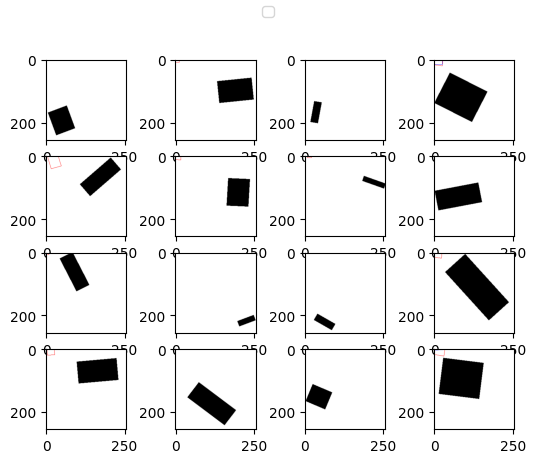

In [15]:
e, d = 10,1
fig, axs = plt.subplots(4,4)

for i in range(4):
    for j in range(4):
        # aa = 0
        result = checkDrawingsForEpoche(epoch = 1, drawing=d + i*4 + j)
        result = checkDrawingsForEpoche(epoch = e, drawing=d + i*4 + j, base_img=result, color=(0,0,255))
        axs[i][j].imshow(result)
str_ = str(f"red - random blue - {e}")
fig.legend(str_, loc='upper center')
plt.show()
        # total = checkDrawingsForEpoche(epoch = 1, drawing=d + i*4 + j) + checkDrawingsForEpoche(epoch = e, drawing=d + i*4 + j, color=(0,0,255))
        # axs[i][j].imshow(checkDrawingsForEpoche(epoch = 1, drawing=d + i*4 + j))
        # axs[i][j].plot(checkDrawingsForEpoche(epoch = 1, drawing=d + i*4 + j))
        # axs[i][j].imshow(checkDrawingsForEpoche(epoch = 1, drawing=d + i*4 + j))
        # axs[i][j].imshow(checkDrawingsForEpoche(epoch = e, drawing=d + i*4 + j, color=(0,0,255)))

# fig, axs = plt.subplots(4,4)
# for i in range(4):
#     for j in range(4):
#         axs[i][j].imshow(checkDrawingsForEpoche(epoch = 1, drawing=d + i*4 + j))


In [ ]:
# b = y_test[3].cpu().detach().numpy().astype(dtype=int).tolist()
# rect = ((b[0], b[1]), (b[2], b[3]), b[4])
# box = cv2.boxPoints(rect)
# box = np.int0(box)
# whiteblankimage = 255 * np.ones(shape=[256, 256, 3], dtype=np.uint8)
# cv2.drawContours(whiteblankimage,[box],0,(0,0,0),thickness=cv2.FILLED)
huinet = HuiNet()
huinet.float()
huinet.load_state_dict(torch.load(f"states_3.1.1/state{54}.txt"))
huinet.eval()
huinet = huinet.to(device)
whitenoise = torch.tensor(np.random.randint(0,255,(256,256)),dtype=torch.float32)
whitenoise = whitenoise.to(device)

huinet.layers_list[0].reset_parameters()

im =  huinet.layers_list[0](whitenoise.reshape(1, 1,256,256)).cpu().detach().numpy().astype(dtype=int).reshape(16,129,129)
# im = huinet.layers_list[1](im)
# im = huinet.layers_list[2](im)
# plt.imshow(im[7])
# print(im[5])

fig, axs = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        axs[i][j].imshow(im[i*4+j],cmap="gray",vmin=0,vmax=255)
        axs[i][j].set_axis_off()

In [ ]:
plt.imshow(whitenoise.cpu().numpy(),cmap="gray", vmin=0,vmax=255)